In [1]:
import os
import sys

from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import fashion_mnist
from keras.layers import Add, BatchNormalization, Conv2D, Dense, Input, Lambda, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [28]:
input_img = Input(shape=(28, 28, 1))
shape_input = Input(shape=(14,))
shape_input_reshaped = Reshape((1, 1, 14))(shape_input)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# Block 1
# Convolution
x = Conv2D(36, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(36, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(36, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Upsample
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)


# Block 2
# Add
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 4, 4, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 4, 4, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 4, 4, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = BatchNormalization()(x)

# Upsample
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Block 3
# Add
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 8, 8, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 8, 8, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 8, 8, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = BatchNormalization()(x)

# Upsample
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Block 4
# Add
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 16, 16, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 16, 16, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = Conv2D(14, (3, 3), activation='relu', padding='same')(x)
shape_vec = Lambda(lambda x: K.tile(x, [1, 16, 16, 1]))(shape_input_reshaped)
x = Add()([x, shape_vec])
x = BatchNormalization()(x)

# Upsample
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

# Block 5
# Convolution
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='last_conv')(x)

autoencoder = Model(inputs=[input_img, shape_input], outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_logarithmic_error')


In [29]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# adapt this if using `channels_first` image data format
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

x_train_repeated = []
x_train_transformed = []
train_shapes = []
for i in range(x_train.shape[0]):
    for _ in range(5):
        translation = np.random.randint(0, 14) * 2
        x_train_repeated.append(x_train[i])
        x_train_transformed.append(
            np.hstack([x_train[i, :, translation:], 
                       x_train[i, :, :translation]]))
        train_shape = np.zeros(14)
        train_shape[translation // 2] = 1
        train_shapes.append(train_shape)

del x_train

x_train_repeated = np.asarray(x_train_repeated)
x_train_transformed = np.asarray(x_train_transformed)
train_shapes = np.asarray(train_shapes)

x_test_transformed = []
test_shapes = []
for i in range(x_test.shape[0]):
    translation = np.random.randint(0, 14)
    x_test_transformed.append(
        np.hstack([x_test[i, :, translation:],
                    x_test[i, :, :translation]]))
    test_shape = np.zeros(14)
    test_shape[translation // 2] = 1
    test_shapes.append(test_shape)

x_test_transformed = np.asarray(x_test_transformed)
test_shapes = np.asarray(test_shapes)

In [30]:
autoencoder.fit([x_train_repeated, train_shapes], x_train_transformed,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=([x_test, test_shapes], x_test_transformed),
                callbacks=[TensorBoard(log_dir='./logs/cce-fmnist-trans', write_images=True)])


Train on 300000 samples, validate on 10000 samples
Epoch 1/50
300000/300000 [==============================] - 54s 180us/step - loss: 0.0170 - val_loss: 0.0147
Epoch 2/50
300000/300000 [==============================] - 53s 177us/step - loss: 0.0117 - val_loss: 0.0150
Epoch 3/50
300000/300000 [==============================] - 53s 177us/step - loss: 0.0106 - val_loss: 0.0130
Epoch 4/50
300000/300000 [==============================] - 53s 177us/step - loss: 0.0098 - val_loss: 0.0134
Epoch 5/50
300000/300000 [==============================] - 53s 177us/step - loss: 0.0093 - val_loss: 0.0139
Epoch 6/50
300000/300000 [==============================] - 53s 177us/step - loss: 0.0089 - val_loss: 0.0146
Epoch 7/50
300000/300000 [==============================] - 53s 176us/step - loss: 0.0085 - val_loss: 0.0133
Epoch 8/50
300000/300000 [==============================] - 53s 177us/step - loss: 0.0083 - val_loss: 0.0135
Epoch 9/50
300000/300000 [==============================] - 53s 176us/step - 

In [7]:
autoencoder.save('./logs/mse-201/model')

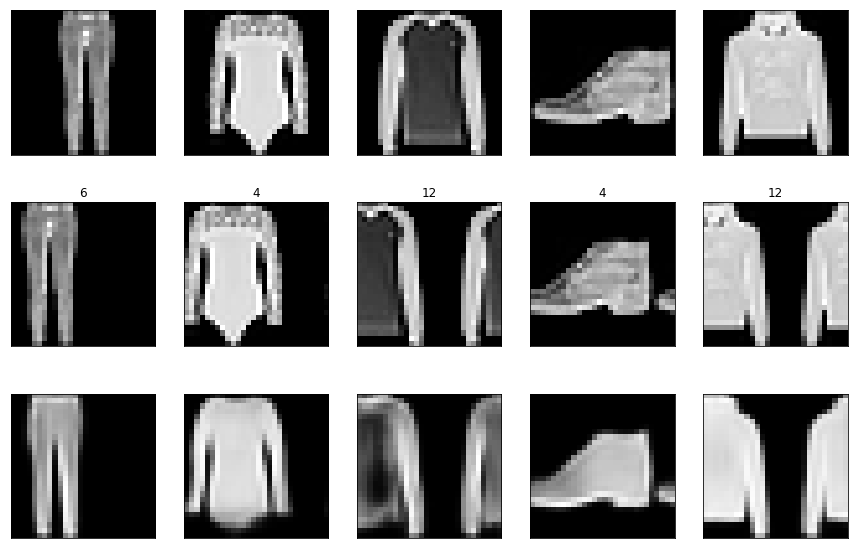

In [23]:
decoded_imgs = autoencoder.predict([x_test, test_shapes])

n = 5
plt.figure(figsize=(15, 10))
start_index = np.random.randint(1, 10000)
for i in range(start_index, start_index + n):
    # display original
    plot_index = i - start_index + 1
    ax = plt.subplot(3, n, plot_index)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display rotated
    plot_index = i + n - start_index + 1
    ax = plt.subplot(3, n, plot_index)
    plt.title(test_shapes[i].argmax() * 2)
    plt.imshow(x_test_transformed[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    plot_index = i - start_index + 1 + 2 * n
    ax = plt.subplot(3, n, plot_index)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)